# Tutorial: Building Fallbacks to Websearch with Conditional Routing

- **Level**: Beginner
- **Time to complete**: 10 minutes
- **Components Used**: [`ConditionalRouter`](https://docs.haystack.deepset.ai/v2.0/docs/conditionalrouter), [`SerperDevWebSearch`](https://docs.haystack.deepset.ai/v2.0/docs/serperdevwebsearch), [`PromptBuilder`](https://docs.haystack.deepset.ai/v2.0/docs/promptbuilder), [`OpenAIGenerator`](https://docs.haystack.deepset.ai/v2.0/docs/openaigenerator)
- **Prerequisites**: You must have an [Open API Key](https://platform.openai.com/api-keys) and a [Serper API Key](https://serper.dev/api-key) for this tutorial
- **Goal**: After completing this tutorial, you'll have learned how to create a pipeline with conditional routing

> This tutorial uses Haystack 2.0 Beta. To learn more, read the [ Haystack 2.0 Beta announcement](https://haystack.deepset.ai/blog/introducing-haystack-2-beta-and-advent) or visit the [Haystack 2.0 Documentation](https://docs.haystack.deepset.ai/v2.0/docs).


## Overview

When developing applications using **retrieval augmented generation ([RAG](https://www.deepset.ai/blog/llms-retrieval-augmentation))**, the retrieval step plays a critical role. It serves as the primary information source for **large language models (LLMs)** to generate responses. However, if your database lacks the necessary information, the retrieval step's effectiveness is limited. In such scenarios, it may be practical to use the web as a fallback data source for your RAG application. By implementing a conditional routing mechanism in your system, you gain complete control over the data flow, enabling you to design a system that can leverage the web as its data source under some conditions.

In this tutorial, you will learn how to create a pipeline with conditional routing that directs the query to a **web-based RAG** route if the answer is not found in the initially given documents.

## Development Environment

### Prepare the Colab Environment

- [Enable GPU Runtime in Colab](https://docs.haystack.deepset.ai/v2.0/docs/enabling-gpu-acceleration)
- [Set logging level to INFO](https://docs.haystack.deepset.ai/v2.0/docs/setting-the-log-level)

### Install Haystack

Install Haystack 2.0 Beta with `pip`:

In [ ]:
%%bash

pip install haystack-ai

### Enable Telemetry

Knowing you're using this tutorial helps us decide where to invest our efforts to build a better product but you can always opt out by commenting the following line. See [Telemetry](https://docs.haystack.deepset.ai/v2.0/docs/telemetry) for more details.

In [ ]:
from haystack.telemetry import tutorial_running

tutorial_running(36)

### Enter API Keys

Enter API keys required for this tutorial.

In [3]:
from getpass import getpass
import os

os.environ["OPENAI_API_KEY"] = getpass("Enter OpenAI Api key: ")
os.environ["SERPERDEV_API_KEY"] = getpass("Enter Serper Api key: ")

Enter OpenAI Api key: ··········
Enter Serper Api key: ··········


## Creating a Document

Create a Document about Munich, where the answer to your question will be initially searched:

In [2]:
from haystack.dataclasses import Document

documents = [
    Document(
        content="""Munich, the vibrant capital of Bavaria in southern Germany, exudes a perfect blend of rich cultural
                                heritage and modern urban sophistication. Nestled along the banks of the Isar River, Munich is renowned
                                for its splendid architecture, including the iconic Neues Rathaus (New Town Hall) at Marienplatz and
                                the grandeur of Nymphenburg Palace. The city is a haven for art enthusiasts, with world-class museums like the
                                Alte Pinakothek housing masterpieces by renowned artists. Munich is also famous for its lively beer gardens, where
                                locals and tourists gather to enjoy the city's famed beers and traditional Bavarian cuisine. The city's annual
                                Oktoberfest celebration, the world's largest beer festival, attracts millions of visitors from around the globe.
                                Beyond its cultural and culinary delights, Munich offers picturesque parks like the English Garden, providing a
                                serene escape within the heart of the bustling metropolis. Visitors are charmed by Munich's warm hospitality,
                                making it a must-visit destination for travelers seeking a taste of both old-world charm and contemporary allure."""
    )
]

## Creating the Initial Pipeline Components

First, define a prompt instructing the LLM to respond with the text `"no_answer"` if the provided documents do not offer enough context to answer the query. Next, initialize a [PromptBuilder](https://docs.haystack.deepset.ai/v2.0/docs/promptbuilder) with that prompt. It's crucial that the LLM replies with `"no_answer"` as you will use this keyword to indicate that the query should be directed to the fallback web search route.

As the LLM, you will use an [OpenAIGenerator](https://docs.haystack.deepset.ai/v2.0/docs/openaigenerator) with the `gpt-3.5-turbo` model.

> The provided prompt works effectively with the `gpt-3.5-turbo` model. If you prefer to use models with different generators, you may need to update the prompt to provide clearer instructions to your model.

In [42]:
from haystack.components.builders.prompt_builder import PromptBuilder
from haystack.components.generators import OpenAIGenerator

prompt_template = """
Answer the following query given the documents.
If the answer is not contained within the documents reply with 'no_answer'
Query: {{query}}
Documents:
{% for document in documents %}
  {{document.content}}
{% endfor %}
"""

prompt_builder = PromptBuilder(template=prompt_template)
llm = OpenAIGenerator(model="gpt-3.5-turbo")

## Initializing the Web Search Components

Initialize the necessary components for a web-based RAG application. Along with a `PromptBuilder` and an `OpenAIGenerator`, you will need a [SerperDevWebSearch](https://docs.haystack.deepset.ai/v2.0/docs/serperdevwebsearch) to retrieve relevant documents for the query from the web.

> If desired, you can use a different [Generator](https://docs.haystack.deepset.ai/v2.0/docs/generators) for the web-based RAG branch of the pipeline.

In [43]:
from haystack.components.builders.prompt_builder import PromptBuilder
from haystack.components.generators import OpenAIGenerator
from haystack.components.websearch.serper_dev import SerperDevWebSearch

prompt_for_websearch = """
Answer the following query given the documents retrieved from the web.

Query: {{query}}
Documents:
{% for document in documents %}
  {{document.content}}
{% endfor %}
"""

websearch = SerperDevWebSearch()
prompt_builder_for_websearch = PromptBuilder(template=prompt_for_websearch)
llm_for_websearch = OpenAIGenerator(model="gpt-3.5-turbo")

## Creating the ConditionalRouter

[ConditionalRouter](https://docs.haystack.deepset.ai/v2.0/docs/conditionalrouter) is the component that handles data routing on specific conditions. You need to define a `condition`, an `output`, an `output_name` and an `output_type` for each route. Each route that the `ConditionalRouter` creates acts as the output of this component and can be connected to other components in the same pipeline.  

In this case, you need to define two routes:
- If the LLM replies with the `"no_answer"` keyword, the pipeline should perform web search. It means that you will put the original `query` in the output value to pass to the next component (in this case the next component will be the `SerperDevWebSearch`) and the output name will be `go_to_websearch`.
- Otherwise, the given documents are enough for an answer and pipeline execution ends here. Return the LLM reply in the output named `answer`.

In [44]:
from haystack.components.routers import ConditionalRouter

routes = [
    {
        "condition": "{{'no_answer' in replies[0]}}",
        "output": "{{query}}",
        "output_name": "go_to_websearch",
        "output_type": str,
    },
    {
        "condition": "{{'no_answer' not in replies[0]}}",
        "output": "{{replies[0]}}",
        "output_name": "answer",
        "output_type": str,
    },
]

router = ConditionalRouter(routes)

## Building the Pipeline

Add all components to your pipeline and connect them. `go_to_websearch` output of the `router` should be connected to the `websearch` to retrieve documents from the web and also to `prompt_builder_for_websearch` to use in the prompt.

In [45]:
from haystack import Pipeline

pipe = Pipeline()
pipe.add_component("prompt_builder", prompt_builder)
pipe.add_component("llm", llm)
pipe.add_component("router", router)
pipe.add_component("websearch", websearch)
pipe.add_component("prompt_builder_for_websearch", prompt_builder_for_websearch)
pipe.add_component("llm_for_websearch", llm_for_websearch)

pipe.connect("prompt_builder", "llm")
pipe.connect("llm.replies", "router.replies")
pipe.connect("router.go_to_websearch", "websearch.query")
pipe.connect("router.go_to_websearch", "prompt_builder_for_websearch.query")
pipe.connect("websearch.documents", "prompt_builder_for_websearch.documents")
pipe.connect("prompt_builder_for_websearch", "llm_for_websearch")

### Visualize the Pipeline

To understand how you formed this pipeline with conditional routing, use [draw()](https://docs.haystack.deepset.ai/v2.0/docs/drawing-pipeline-graphs) method of the pipeline. If you're running this notebook on Google Colab, the generated file will be saved in "Files" section on the sidebar or you can call `Image.open()`:

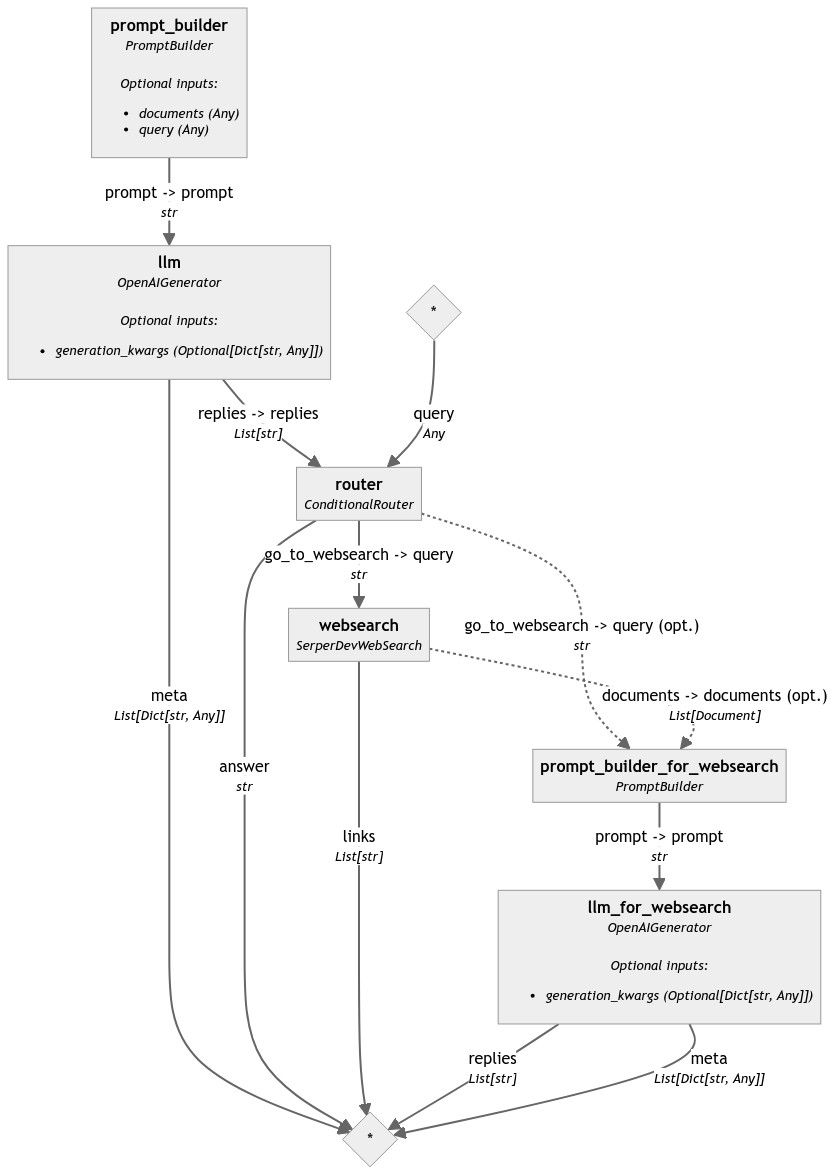

In [10]:
from PIL import Image

pipe.draw("pipe.png")
Image.open("pipe.png")

## Running the Pipeline!

In the `run()`, pass the query to the `prompt_builder` and the `router`. In real life applications, `documents` will be provided by a [Retriever](https://docs.haystack.deepset.ai/v2.0/docs/retrievers) but to keep this example simple, you will provide the defined `documents` to the `prompt_builder`.

In [46]:
query = "Where is Munich?"

result = pipe.run({"prompt_builder": {"query": query, "documents": documents}, "router": {"query": query}})

# Print the `answer` coming from the ConditionalRouter
print(result["router"]["answer"])

Munich is the vibrant capital of Bavaria in southern Germany.


✅ The answer to this query can be found in the defined document.

Now, try a different query that doesn't have an answer in the given document and test if the web search works as expected:

In [47]:
query = "How many people live in Munich?"

result = pipe.run({"prompt_builder": {"query": query, "documents": documents}, "router": {"query": query}})

# Print the `replies` generated using the web searched Documents
print(result["llm_for_websearch"]["replies"])

['According to the documents retrieved, the population of Munich is estimated to be:\n- 1.472 million (2019)\n- 1,578,132 inhabitants as of 31 May 2022\n- 1,584,507 in 2024\n- 830,977 in 1950\n- 1,259,677 in December 2005\n- 1,585,000 in 2024 (metro area population)\n- 1,576,000 in 2023 (metro area population)\n\nThe exact current population is not mentioned in the given documents, but the closest estimate is 1,584,507.']


If you check the whole result, you will see that `websearch` component also provides links to Documents retrieved from the web:

In [48]:
result

{'llm': {'meta': [{'model': 'gpt-3.5-turbo-0613',
    'index': 0,
    'finish_reason': 'stop',
    'usage': {'completion_tokens': 2,
     'prompt_tokens': 271,
     'total_tokens': 273}}]},
 'websearch': {'links': ['https://en.wikipedia.org/wiki/Munich',
   'https://worldpopulationreview.com/world-cities/munich-population',
   'https://en.wikipedia.org/wiki/Demographics_of_Munich',
   'https://www.macrotrends.net/cities/204371/munich/population',
   'https://www.britannica.com/place/Munich-Bavaria-Germany',
   'https://www.statista.com/statistics/519723/munich-population-by-age-group/',
   'https://www.citypopulation.de/en/germany/bayern/m%C3%BCnchen_stadt/09162000__m%C3%BCnchen/',
   'https://www.quora.com/How-many-people-live-in-Munich',
   'https://earth.esa.int/web/earth-watching/image-of-the-week/content/-/article/munich-germany/']},
 'llm_for_websearch': {'replies': ['According to the documents retrieved, the population of Munich is estimated to be:\n- 1.472 million (2019)\n- 1,5

## What's next

🎉 Congratulations! You've built a pipeline with conditional routing! You can now customize the condition for your specific use case and create a custom Haystack 2.0 pipeline to meet your needs.

If you liked this tutorial, there's more to learn about Haystack 2.0:
- [Creating Your First QA Pipeline with Retrieval-Augmentation](https://haystack.deepset.ai/tutorials/27_first_rag_pipeline)
- [Model-Based Evaluation of RAG Pipelines](https://haystack.deepset.ai/tutorials/35_model_based_evaluation_of_rag_pipelines)

To stay up to date on the latest Haystack developments, you can [sign up for our newsletter](https://landing.deepset.ai/haystack-community-updates?utm_campaign=developer-relations&utm_source=tutorial&utm_medium=conditional-router) or [join Haystack discord community](https://discord.gg/haystack).

Thanks for reading!